<center><h1>Predicting the Presence of Diabetes</h1></center>

<center><img src="https://cutiscareusa.com/wp-content/uploads/2021/11/CutisCare-Website-Banners.jpg" width=800 /></center>

# Project Description

This <a href='https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset'>dataset</a> was retrieved from Kaggle.com. It contains the medical and demographic data from patients, along with their diabetes status. The project will use this dataset to predict a patient's diabetes status.

# Project Goals

Using classification techniques, my aim is to create a model that can accurately predict whether a patient has diabetes that performs better than baseline.

# Initial Hypothesis

My running hypothesis is that HbA1c levels will be the singular best predictor of whether someone has diabetes. However, I do believe that all features present in the data will contribute to the accuracy of our model.

# Data Dictionary

Column Name | Description | Key
:--- | :--- | :---
gender | Patient's Gender | Male, Female, Other
age | Patient's Age | Int
hypertension | Hypertension diagnosis | 0 = No, 1 = Yes
heart_disease | Heart disease diagnosis | 0 = No, 1 = Yes
smoking_history | Patient's smoking history | (Column Removed)
bmi | Patient's BMI score | Float
HbA1c_level | Patient's HbA1c level (average blood sugar level over the past 2-3 months) | Float
blood_glucose_level | Patient's blood glucose level (see note in notebook) | Float
diabetes | Diabetes diagnosis | 0 = No, 1 = Yes 

# Project Pipeline

In [1]:
#Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## Acquire

- Retrieve dataset from <a href='https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset'>Kaggle</a>, save .csv file to local repository. Read file in Jupyter.
- Check .head( ), .info( ), .describe( ), .shape

In [2]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


There are no nulls in this dataset.

In [4]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


In [5]:
diabetes.shape

(100000, 9)

## Prepare

We'll start with visualizing distributions of numerical values and counts of categorical values.

### Univariate Exploration

In [6]:
numeric = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical = ['gender', 'hypertension', 'smoking_history', 'heart_disease', 'diabetes']

**Histograms**

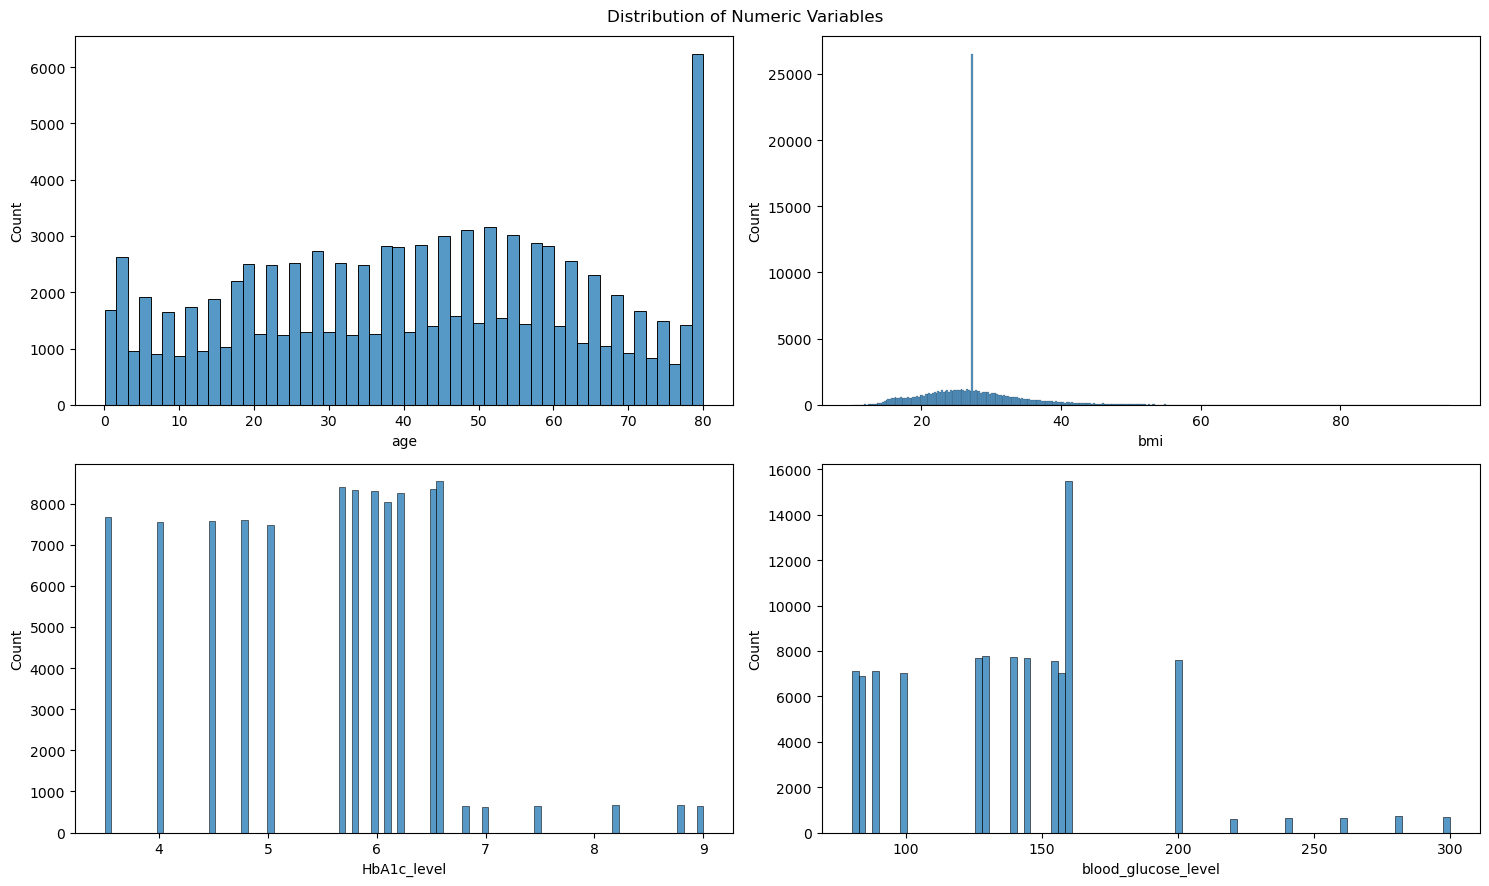

In [7]:
plt.figure(figsize=(15,9))
plt.suptitle('Distribution of Numeric Variables')
for i, col in enumerate(diabetes[numeric]):
    plt.subplot(2,2,(i+1))
    sns.histplot(diabetes[col])
plt.tight_layout()
plt.show()

**Notes**:

- Age contains odd gaps. Looking at the values, we have floats for age. This will change during preparation.
- Something seems very off in BMI. One singular, very specific value seems to be the vast majority of cases, which is odd.

In [8]:
diabetes.bmi.value_counts().head(3) 

#The value 27.32 makes up 25.5% of the data. Reading through medical literature, nothing states that 27.32 is
#somehow the most overwhelmingly common BMI to have. As the preponderance is suspicious, I'll be removing this value.

27.32    25495
23.00      103
27.12      101
Name: bmi, dtype: int64

**Boxplots**

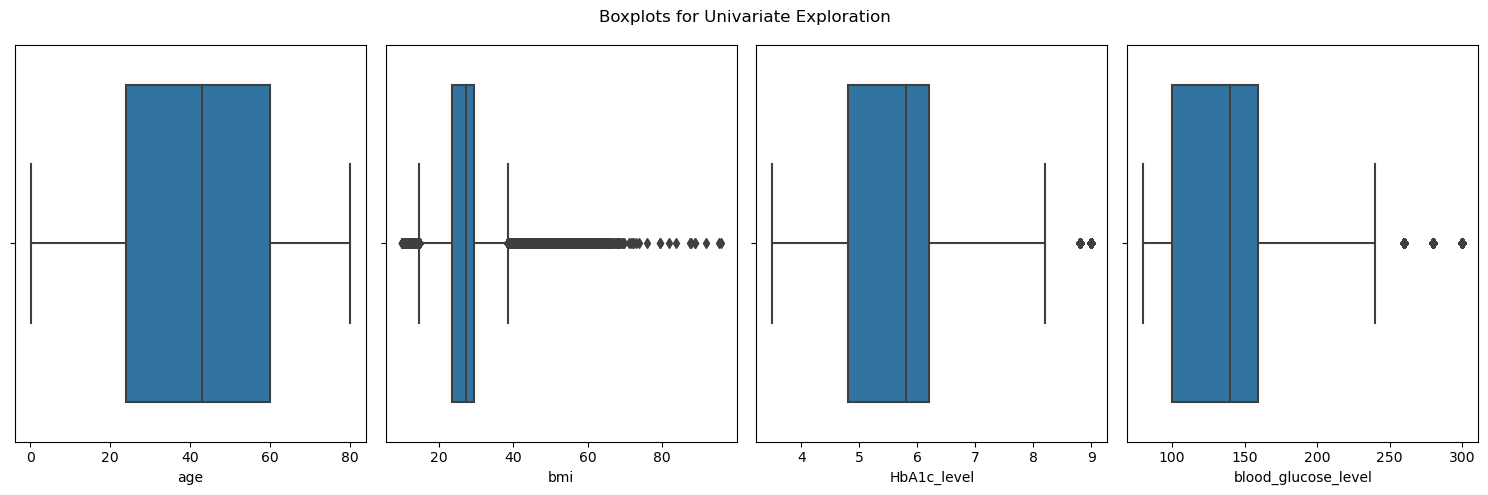

In [9]:
plt.figure(figsize=(15,5))
plt.suptitle('Boxplots for Univariate Exploration')
for i, col in enumerate(diabetes[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]):
    plt.subplot(1,4,(i+1))
    sns.boxplot(diabetes[col])
plt.tight_layout()
plt.show()

**Notes**:

- Seems to be a lot of outliers for BMI. I'll snip off some of the higher end after getting rid of the value I had mentioned.

**Barplots**

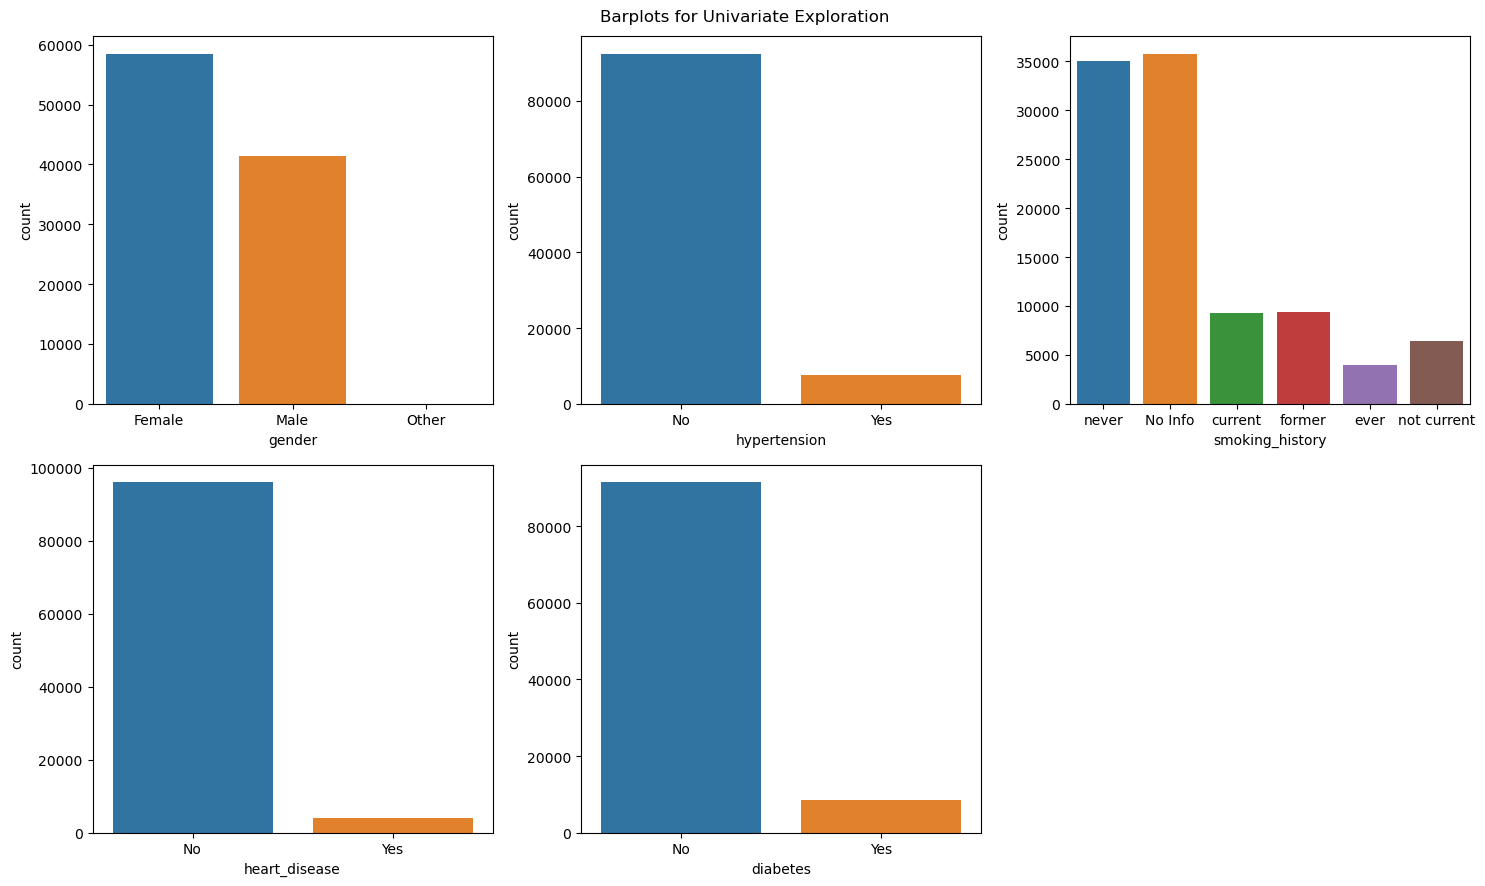

In [10]:
plt.figure(figsize=(15,9))
plt.suptitle('Barplots for Univariate Exploration')
for i, col in enumerate(diabetes[categorical]):
    if diabetes[col].dtype == 'O':
        plt.subplot(2,3,(i+1))
        sns.countplot(diabetes[col])
    else:
        plt.subplot(2,3,(i+1))
        sns.countplot(diabetes[col]).set_xticklabels(labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

**Value Counts**

In [11]:
for col in diabetes[categorical]:
    print('')
    print(diabetes[col].value_counts())
    print('')
    print('---------------------------')


Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

---------------------------

0    92515
1     7485
Name: hypertension, dtype: int64

---------------------------

No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64

---------------------------

0    96058
1     3942
Name: heart_disease, dtype: int64

---------------------------

0    91500
1     8500
Name: diabetes, dtype: int64

---------------------------


**Notes**

- 'Other' in gender is only 0.02% of the dataset. We will remove this value.
- 'No Info' in 'smoking_history' is 35.8% of the data. 'ever' value is also ambiguous. We will remove this column for clarity's sake.

**Things to Do**

- There were no nulls in this dataset, so nothing additional needed to be done in this regard.
- Fix age so it's rounded to the nearest whole number and converted to an integer.
- Drop smoking_history for MVP since No Info makes up 36% the dataset.
- Given the oddly high amount of occurences, remove all BMI values that are exactly 27.32.
- Reduce BMI to snip out top .05% of values.
- Drop "Other" from gender since it's only .02% of dataset.
- Keeping 0s and 1s in hypertension, heart disease, and diabetes for future modeling, will relabel to Yes and No for clarification during exploration on graphs alone.
- Encode string values for gender for future modeling.
- Split into train, validate, test.

In [12]:
import prep

diabetes = prep.prep_diabetes(diabetes)

diabetes.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_encoded
0,Female,80,0,1,25.19,6.6,140,0,0
3,Female,36,0,0,23.45,5.0,155,0,0
4,Male,76,1,1,20.14,4.8,155,0,1
6,Female,44,0,0,19.31,6.5,200,1,0
7,Female,79,0,0,23.86,5.7,85,0,0


In [13]:
train, validate, test = prep.split_data(diabetes, 'diabetes')

In [14]:
train.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_encoded
97196,Female,53,0,0,34.49,4.0,85,0,0
2129,Male,5,0,0,16.17,3.5,80,0,1
77812,Male,44,0,0,39.61,3.5,90,0,1
94778,Female,32,0,0,23.23,6.6,160,0,0
28491,Female,20,0,0,20.74,6.0,90,0,0


***Note! Regarding blood_glucose_level***

Looking at the Discussion Board on Kaggle, it is unclear as to how this measurement was taken. Blood glucose tests have an additional parameter as to whether or not the patient was fasting when this value was obtained. Fasting/no fasting greatly influences this value. However, for MVP, this will remain in the dataframe at least through exploration.

From Kaggle:
> The dataset does not specify whether the glucose levels represent the last blood glucose check of a 2-hour glucose tolerance test or the first check after an eight-hour fasting. Instead, the measurements seem to be taken without specific fasting requirements or as part of a standardized test.

# Exploration

### Bivariate Exploration

First, I'll look for any variables that might be suspect for multicollinearity.

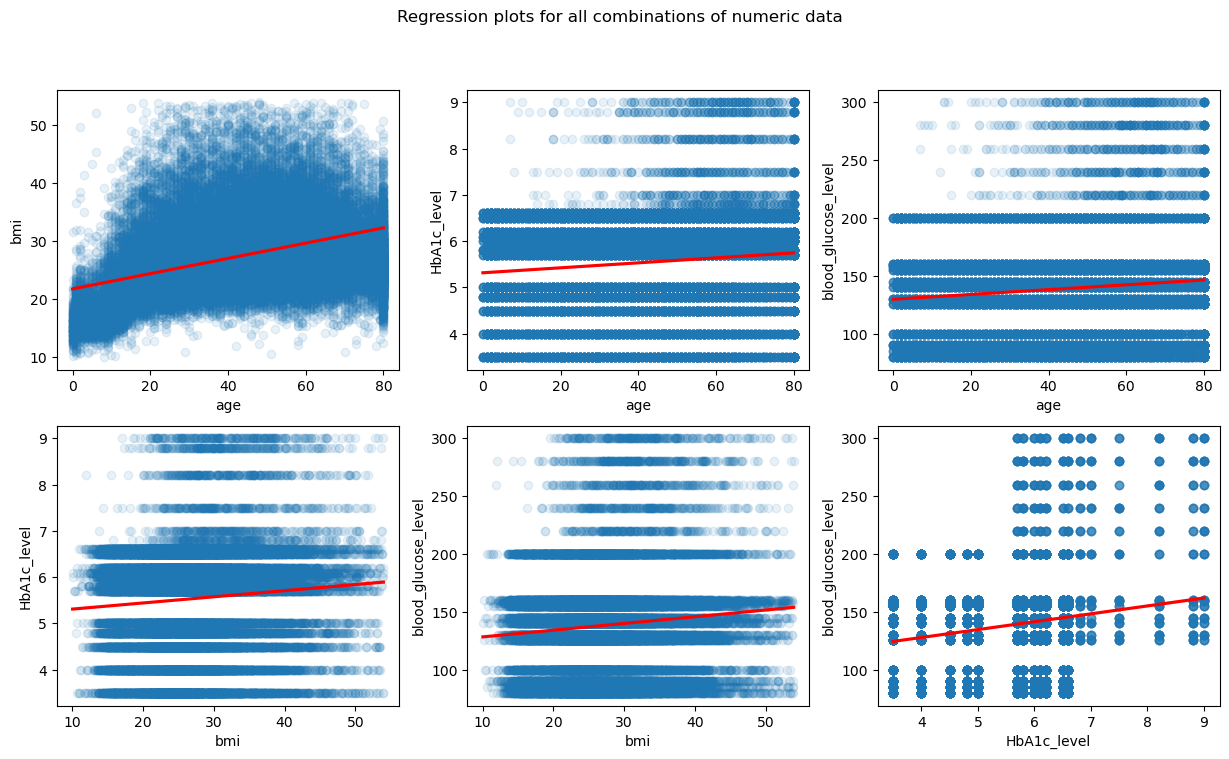

In [15]:
#For numeric categories

prep.visualize_numerical(train)

**Notes**

- Nothing particularly eye-popping here. Nevertheless, going to test for multicollinearity for age vs BMI, and HbA1c vs blood glucose, since I know HbA1C is the average of blood glucose over the past 2-3 months.

Next, I'll visualize the relationships between numeric features vs. target and categorical features vs. target.

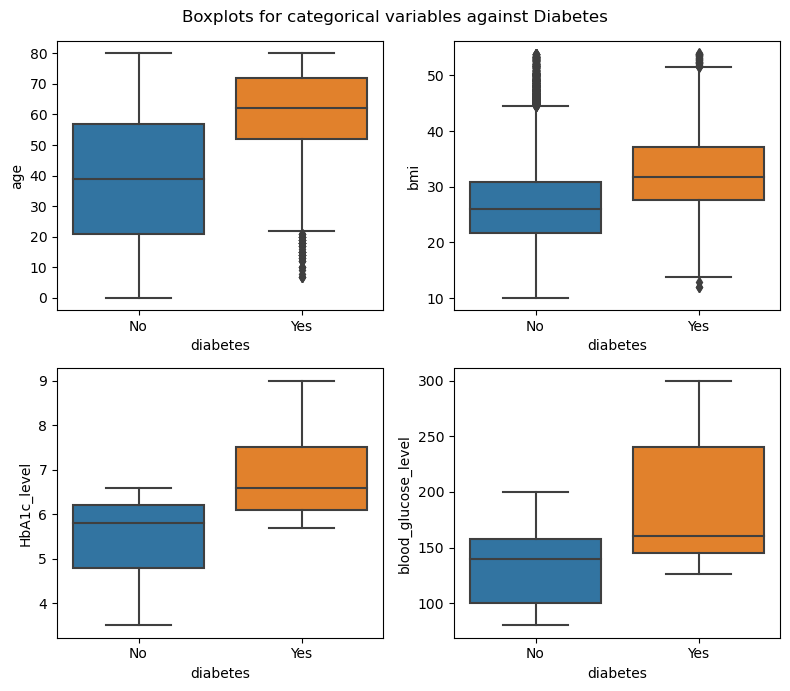

In [16]:
#Numeric against Target Variable

plt.figure(figsize=(8,7))
plt.suptitle('Boxplots for categorical variables against Diabetes')
for i, col in enumerate(train[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']]):
    if col != 'diabetes':
        plt.subplot(2,2,(i+1))
        sns.boxplot(data=train, x='diabetes', y=col).set_xticklabels(labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

**Notes**

- Definitely a significant difference in distributions and medians across all variables. Will run two-tailed t-test for each one.

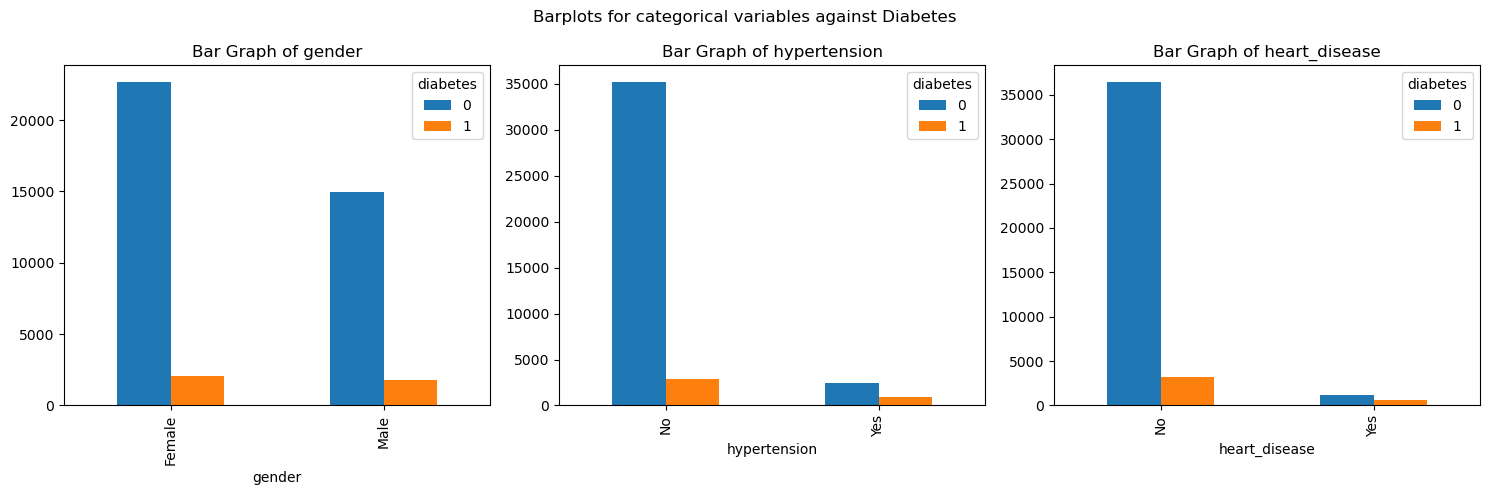

In [17]:
#Categorical against Target Variable

prep.visualize_cat_target(train)

**Notes**

All three features also seem to differ significantly amongst those who do and do not have diabetes. E.g. there is a greater percentage of people that have hypertension that also has diabetes then those who do not have hypertension but has diabetes. We'll be sending these into a chi-squared test to check for statistical significance.

### Multivariate Exploration

Next, we'll set diabetes as a hue to look for any clusters.

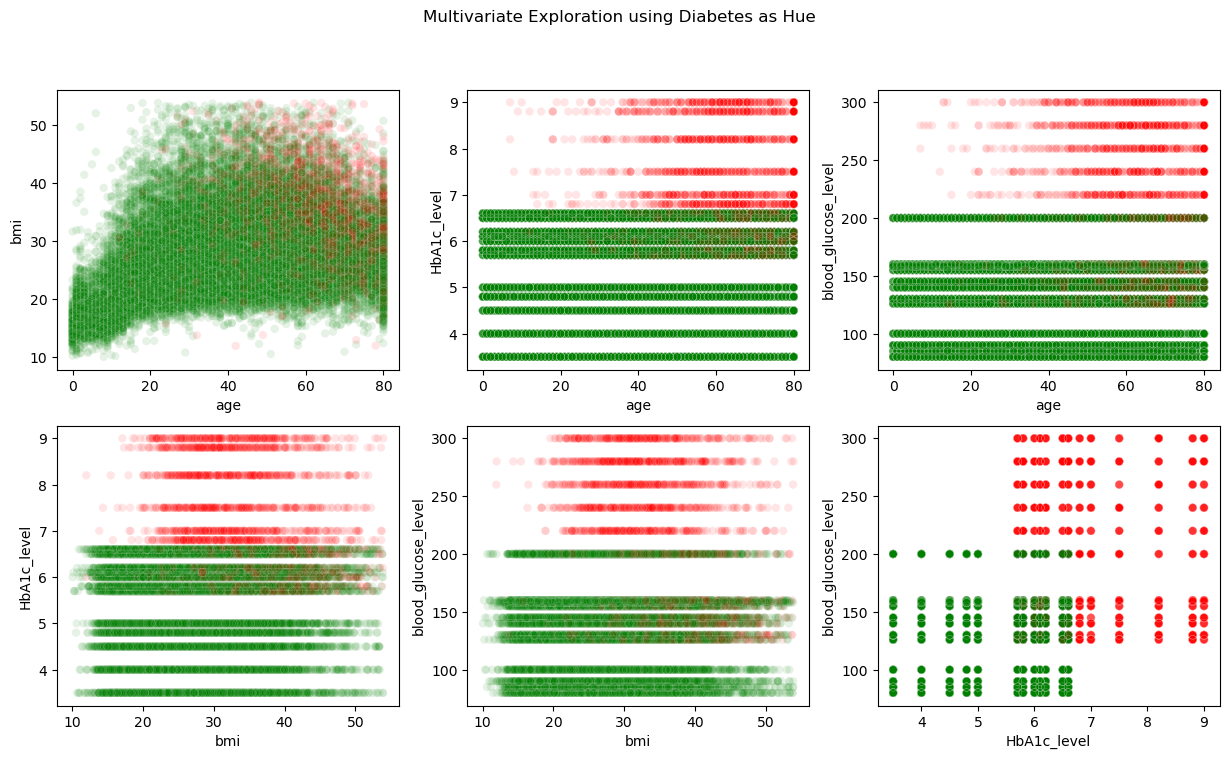

In [18]:
prep.visualize_multivariate(train)

**Notes**

Blood glucose and HbA1c has two very distinct clusters. 

During my second iteration, I manually created a cluster model using the following code: 

```train['Hb_bg_cluster'] = np.where(((train.HbA1c_level <= 6.7) & (train.blood_glucose_level <= 200)), 0, 1)```

However, even though the cluster accurately reflected the observed values, it did not increase the accuracy of our models, so all subsequent steps related to clustering was removed in the final presentation.

### Hypothesize - Stats Tests

For all our tests, our $\alpha$ will be set to 0.05.

**Multicollinearity**

Q: Is there multicollinearity occuring between age and bmi? What about blood glucose and HbA1c levels?

$H_0$: There is no multicollinearity between age vs bmi and blood glucose vs HbA1c.

$H_\alpha$: There is multicollinearity between age vs bmi and blood glucose vs HbA1c.

In [19]:
list_to_check = [['age','bmi'],['HbA1c_level','blood_glucose_level']]

prep.check_multicollinearity(train, list_to_check)

,variable_1,variable_2,correlation,p-value
0,age,bmi,0.407388,0.000000e+00
1,HbA1c_level,blood_glucose_level,0.177288,3.299560e-290


Both combinations are correlated, given that the p-value is less than $\alpha$. However, because the correlation values are not high, we can rule out collinearity.

**Comparison of Means**

Are our numeric variables affecting whether someone has diabetes? I.e. if someone is older, has higher blood glucose/HbA1c levels, and/or greater BMI, will that increase their likelihood of having diabetes?

$H_0$: There is no difference in the means between our numeric variables and our target variable.

$H_\alpha$: There is a difference in the means between our numeric variables and our target variable.

In [20]:
prep.check_comparison_of_means(train, numeric)

,variable,equal_variance,t_stat,p_value
0,HbA1c_level,False,-83.927300,0.0
1,age,False,-82.056352,0.0
2,blood_glucose_level,False,-63.592501,0.0
3,bmi,True,-49.992131,0.0


**Notes**

- As predicted, HbA1c levels are the strongest predictors of diabetes, given its greater t-stat value. Nevertheless, since all four numeric variables have a p-value of less than $\alpha$, we reject the null hypothesis. We shall send all variables into our model.

**Chi-Squared**

Are our categorical variables also influencing whether someone has diabetes? I.e. if someone has hypertension or heart disease, or if someone is male vs. female, will that affect their likelihood of having diabetes?

$H_0$: Our categorical variables are independent of our target variable.

$H_\alpha$: Our categorical variables are dependent on our target variable.

In [21]:
#Reassigning categorical to remove smoking_history which was dropped from the dataset
categorical = ['gender', 'hypertension', 'heart_disease']

prep.check_chi_squared(train, categorical)

,variable,chi_2,p_value
0,hypertension,1636.115636,0.000000e+00
1,heart_disease,1385.388510,3.144480e-303
2,gender,71.816186,2.362067e-17


**Notes**

- Since our p-value is less than $\alpha$, we can reject the null hypothesis. All three categorical variables show that there is some correlation between said variables and the presence of diabetes, the strongest being hypertension. All three of these as well will be sent into modeling.

## Key Takeaways

- All variables had varying degrees of statistically significant correlation to diabetes.
- A clear cluster is visible when looking at HbA1c, blood glucose levels, and diabetes.
- As all variables have some correlation, all will be sent into modeling. 
- In a nutshell, the older you are and the higher your HbA1c and blood glucose levels are, the more likely you are to have diabetes.
- Additionally, if you have hypertension and/or you have a heart disease, you are more likely to have diabetes.

# Modeling

## Set Baseline

In [22]:
#Use mode of diabetes values to calculate baseline.

len(train[train.diabetes == train.diabetes.mode()[0]]) / len(train)

0.9076059459850145

Our baseline to beat is **90.76%**

## Running Classification Models

Before running the data through our models, we first have to scale our numeric data to account for distance-based modeling (i.e. KNN).

In [23]:
train_scaled, validate_scaled, test_scaled = prep.scale_data(train, validate, test, numeric)

Now, we'll split the data into the features that we want to send into the model (*X_train*), as well as our target variable (*y_train*).

In [24]:
features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender_encoded']

X_train = train_scaled[features]
y_train = train_scaled.diabetes

X_validate = validate_scaled[features]
y_validate = validate_scaled.diabetes

X_test = test_scaled[features]
y_test = test_scaled.diabetes

Next, we'll send it through each of our classification models, adjusting hyperparameters and selecting the model with the least overfit (i.e. least difference between train and validate).

Note that the function below runs the dataset through each model, and within each model, runs the dataset using a range of hyperparameters. The function returns the model along with its respective hyperparameter that had the lowest difference between the train and validate sets.

In [25]:
prep.get_best_model(X_train, y_train, X_validate, y_validate)

,model,train,validate,hyperparameter,hp_value,difference
0,Decision Tree,97.05,97.04,max_depth,10,0.000056
1,KNN,96.30,96.31,n_neighbors,12,0.000105
2,Random Forest,97.02,97.13,"max_depth, min_samples_leaf","10, 1",0.001157
3,Logistic Regression,95.68,95.92,C,0.1,0.002418


Looks like our Decision Tree model performed the best, with a max_depth of 10. We will choose this model going forward to test on our unseen data.

## Running Model on Test

Finally, we will run our model on our unseen data.

In [26]:
prep.run_best_model(X_train, y_train, X_test, y_test)

,model,test,hyperparameter,hp_value
0,Decision Tree,96.9,max_depth,10


Our best model performed within .1%-.2% of our train and validate when tested on our unseen data. Final accuracy: 97%.

# Conclusions

- Our best performing model, Decision Tree with max_depth of 10, outperformed our baseline by 7%, increasing accuracy to 97%.
- All features were found to have some degree of correlation, with HbA1c the strongest of the numeric variables, and hypertension the strongest of the categorical variables.
- During this second iteration, I scaled the data for use in the KNN model. As predicted, the second iteration improved the KNN model (first iteration had an accuracy of ~94%), but it did not perform better than our other models.
- A cluster stood out in the multivariate graph containing HbA1c level, blood glucose level, and diabetes. However, sending in HbA1c and blood glucose together as a cluster did not improve the performance of our models, so I removed it from this presentation.

# Recommendations and Next Steps

- BMI is a notoriously outdated measurement in the medical field, as it does not take into account a patient's body composition, i.e. how much lean muscle mass they have. Collecting data on body fat percentage would probably be a better predictor of diabetes.
- Blood glucose levels should be standardized only to include tests in which the patients are fasting. Glucose levels drastically increase after meals, which can throw off the data when it comes to predicting diabetes. Alternatively, an additional column may be added stating if the measurement was taken while fasting (True) or not (False).

<img src="Conclusion.png" />

<img src='Recs.png' />